Here is a large sparse matrix.

In [1]:
using SparseArrays, LinearAlgebra 
A = 2.8I + sprand(10000,10000,0.002);

Without a preconditioner, GMRES takes a large number of iterations. 

In [2]:
using IterativeSolvers
b = rand(10000)
gmres(A,b,maxiter=300,tol=1e-10,restart=50,log=true);
time_plain = @elapsed x,hist1 = gmres(A,b,maxiter=300,tol=1e-10,restart=50,log=true)

0.209713071

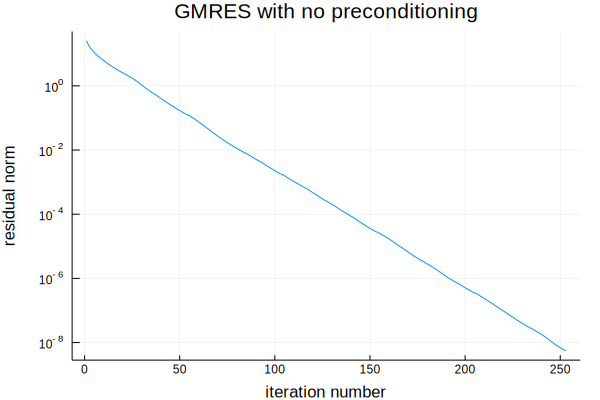

In [3]:
using Plots
plot(hist1[:resnorm],label="", 
    title="GMRES with no preconditioning",
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )

This version of incomplete $LU$ factorization drops all sufficiently small values (i.e., replaces them with zeros). This keeps the number of nonzeros in the factors under control.

In [4]:
using IncompleteLU
iLU = ilu(A,τ=0.2);
@show nnz(A),nnz(iLU.L);

(nnz(A), nnz(iLU.L)) = (209461, 156509)


It does _not_ produce a true factorization of $A$. However, it's close enough to serve as "approximate inverse" in a preconditioner. 

The actual preconditioning matrix is $\mathbf{M}=\mathbf{L}\mathbf{U}$. However, we just supply the factorization as a left preconditioner, since the preconditioning step is to solve a system with the matrix $\mathbf{M}$.

In [5]:
time_prec = @elapsed x,hist2 = gmres(A,b,Pl=iLU,maxiter=300,tol=1e-10,restart=50,log=true)

0.381987436

The preconditioning is fairly successful in this case.

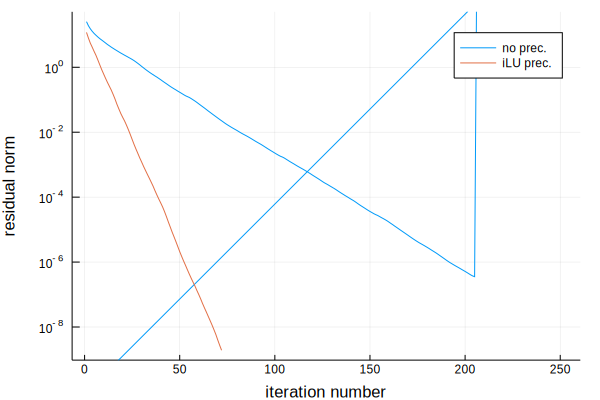

In [6]:
plot(hist1[:resnorm],label="no prec.", 
    xaxis=("iteration number"), yaxis=(:log10,"residual norm") )
plot!(hist2[:resnorm],label="iLU prec.")

We probably made each GMRES iteration slower because of the need to apply the preconditioner (here, by solving sparse triangular systems). However, there are a lot fewer iterations needed, and there is a modest gain overall.